In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
from scipy import stats
from scipy.special import expit
import theano.tensor as tt
import random

from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.metrics import roc_auc_score

random.seed(42)
np.random.seed(42)

sns.set(style="darkgrid")

In [2]:
train = pd.read_csv("../data/train.csv")
train.head()

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,...,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,...,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973
2,2,1.0,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,...,0.013,0.263,-1.222,0.726,1.444,-1.165,-1.544,0.004,0.800,-1.211
3,3,1.0,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,...,-0.404,0.640,-0.595,-0.966,0.900,0.467,-0.562,-0.254,-0.533,0.238
4,4,1.0,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,...,0.898,0.134,2.415,-0.996,-1.006,1.378,1.246,1.478,0.428,0.253


In [3]:
X = train.iloc[:, 2:].values
y = train.iloc[:, 1].values

In [4]:
invlogit = lambda x: 1/(1 + tt.exp(-x))

def get_model(y, X):
    model = pm.Model()
    with model:
        xi = pm.Bernoulli('xi', .05, shape=X.shape[1]) #inclusion probability for each variable
        alpha = pm.Normal('alpha', mu = 0, sd = 5) # Intercept
        beta = pm.Normal('beta', mu = 0, sd = .75 , shape=X.shape[1]) #Prior for the non-zero coefficients
        p = pm.math.dot(X, xi * beta) #Deterministic function to map the stochastics to the output
        y_obs = pm.Bernoulli('y_obs', invlogit(p + alpha),  observed=y)  #Data likelihood
    return model

In [5]:
model1 = get_model(y, X)

with model1:
    trace1 = pm.sample(2000, random_seed=4816, cores=1, progressbar=True, chains=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>BinaryGibbsMetropolis: [xi]
>NUTS: [beta, alpha]
100%|██████████| 2500/2500 [01:35<00:00, 26.09it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


/home/twillard/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/twillard/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/twillard/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd510e80f28>,
      dtype=object)

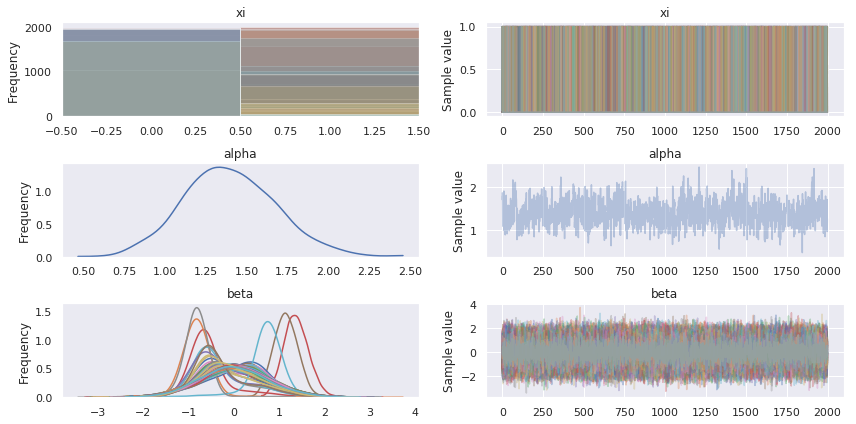

In [6]:
pm.traceplot(trace1)

In [10]:
model2 = get_model(y, X)

with model1:
    trace2 = pm.sample(3000, random_seed=4816, cores=1, progressbar=True, chains=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>BinaryGibbsMetropolis: [xi]
>NUTS: [beta, alpha]
100%|██████████| 3500/3500 [01:45<00:00, 35.02it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


/home/twillard/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/twillard/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/twillard/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd5099cee48>,
      dtype=object)

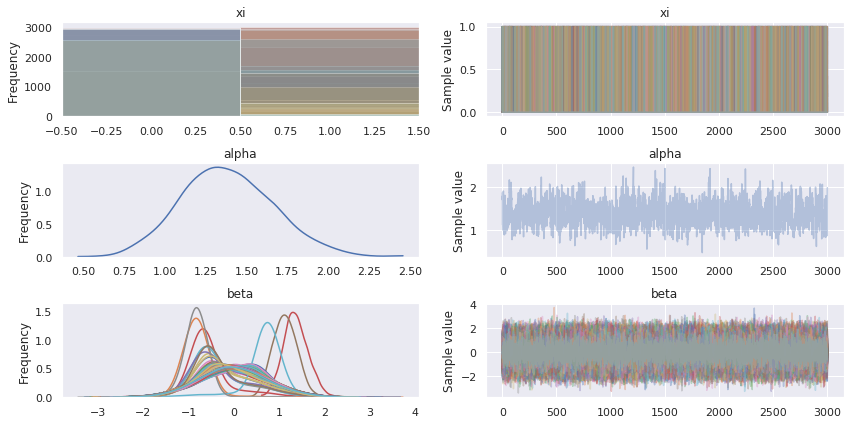

In [11]:
pm.traceplot(trace2)

In [7]:
# results = pd.DataFrame({
#     "var": np.arange(300), 
#     "inclusion_probability": np.apply_along_axis(np.mean, 0, trace['xi']),
#     "beta": np.apply_along_axis(np.mean, 0, trace['beta']),
#     "beta_given_inclusion": np.apply_along_axis(np.sum, 0, trace['xi']*trace['beta'])
#                             /np.apply_along_axis(np.sum, 0, trace['xi'])
# })

In [8]:
results.sort_values('inclusion_probability', ascending=False).head(20)

,var,inclusion_probability,beta,beta_given_inclusion
33,33,1.0000,1.368420,1.368420
65,65,1.0000,1.137482,1.137482
217,217,0.9735,-0.804578,-0.832065
91,91,0.9645,-0.808938,-0.841632
199,199,0.8755,0.678319,0.764465
73,73,0.7830,-0.541422,-0.702273
117,117,0.5640,-0.365669,-0.623717
189,189,0.5070,-0.331801,-0.636151
295,295,0.4795,-0.310432,-0.602241
194,194,0.4625,-0.323346,-0.672507


In [9]:
scores = []
repeated_kfold = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

for train_ix, valid_ix in repeated_kfold.split(X):
    X_train = X[train_ix]
    X_valid = X[valid_ix]
    y_train = y[train_ix]
    y_valid = y[valid_ix]
    
    sample_model = get_model(y, X)

    with model1:
        trace = pm.sample(2000, random_seed=4816, cores=1, progressbar=False, chains=1)
    
    test_beta = trace['beta'][0]
    test_inc = trace['xi'][0]
    test_score = expit(trace['alpha'][0] + np.dot(X_valid, test_inc * test_beta))  

    estimate = trace['beta'] * trace['xi'] 
    y_hat = np.apply_along_axis(np.mean, 1, expit(trace['alpha'] + np.dot(X_valid, np.transpose(estimate))))
    
    scores.append(roc_auc_score(y_valid, y_hat))

scores_mean = np.mean(scores)
scores_std = np.std(scores)
print("AUC = %.5f +/- %.5f"%(scores_mean, scores_std))

Sequential sampling (1 chains in 1 job)
CompoundStep
>BinaryGibbsMetropolis: [xi]
>NUTS: [beta, alpha]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
CompoundStep
>BinaryGibbsMetropolis: [xi]
>NUTS: [beta, alpha]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
CompoundStep
>BinaryGibbsMetropolis: [xi]
>NUTS: [beta, alpha]
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
CompoundStep
>BinaryGibbsMetropolis: [xi]
>NUTS: [beta, alpha]
/home/twillard/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Only one chain was sampled, this makes it impossible to run some convergence checks


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
test = pd.read_csv("../data/test.csv")
X_test = test.iloc[:, 1:].values

In [ ]:
model1 = get_model(y, X)

with model1:
    trace = pm.sample(2000, random_seed=4816, cores=1, progressbar=True, chains=1)
    
test_beta = trace['beta'][0]
test_inc = trace['xi'][0]
test_score = expit(trace['alpha'][0] + np.dot(X_test, test_inc * test_beta))  

estimate = trace['beta'] * trace['xi'] 
y_hat = np.apply_along_axis(np.mean, 1, expit(trace['alpha'] + np.dot(X_test, np.transpose(estimate))))

In [ ]:
submission = pd.DataFrame({"id": test["id"], "target": y_hat})
submission.to_csv("test_logistic_normal_prior_submission.csv", index=False)